In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [17]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [18]:
train_ds, valid_ds = ds['train'], ds['validation']

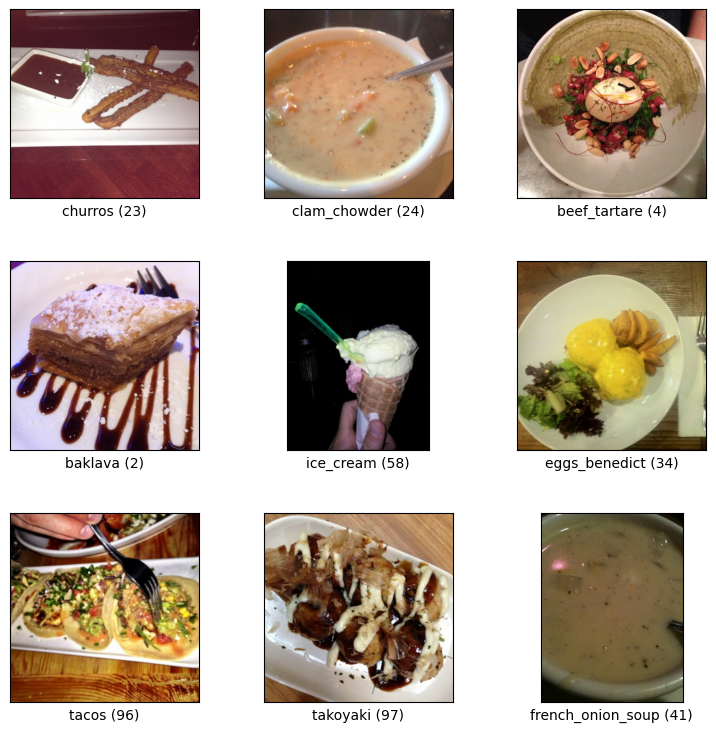

In [19]:
fig = tfds.show_examples(train_ds, ds_info)

In [20]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds =  train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype = tf.int32))

)

valid_ds =  valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype = tf.int32))
)

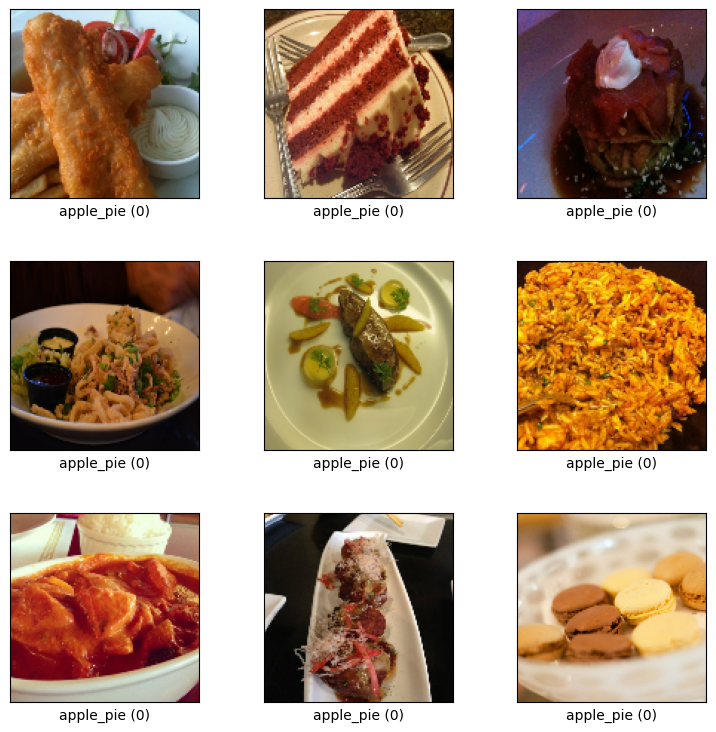

In [21]:
fig = tfds.show_examples(train_ds, ds_info)

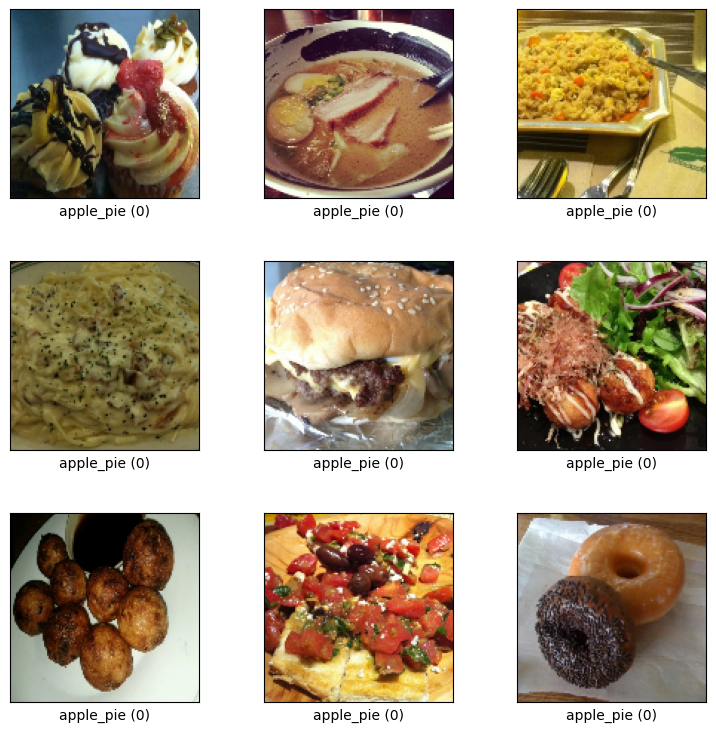

In [22]:
fig = tfds.show_examples(valid_ds, ds_info)

In [23]:
train_hd_size, valid_hd_size = 750, 250

train_hd = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_not_hd = train_ds.filter(lambda image, label: label == 0)

In [24]:
valid_hd = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_not_hd = valid_ds.filter(lambda image, label: label == 0)

In [25]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hd, train_not_hd],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


valid_ds = tf.data.Dataset.sample_from_datasets([valid_hd, valid_not_hd],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)

valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [26]:
for image_batch, label_batch in train_ds.take(2):
  print(image_batch, 'image_batch')
  print(label_batch, 'label_batch')

tf.Tensor(
[[[[211 192 166]
   [209 191 170]
   [219 208 187]
   ...
   [216 205 181]
   [205 192 167]
   [212 197 172]]

  [[202 186 159]
   [207 192 168]
   [210 199 177]
   ...
   [220 210 189]
   [205 193 169]
   [213 199 173]]

  [[201 186 160]
   [214 201 180]
   [214 202 183]
   ...
   [218 209 191]
   [215 204 182]
   [213 200 175]]

  ...

  [[232 224 211]
   [233 225 215]
   [234 225 216]
   ...
   [231 222 210]
   [230 220 207]
   [230 218 203]]

  [[233 225 208]
   [230 221 209]
   [234 225 216]
   ...
   [228 219 208]
   [232 223 209]
   [233 221 206]]

  [[234 226 207]
   [236 226 213]
   [235 225 216]
   ...
   [231 222 210]
   [233 223 210]
   [232 220 205]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


# **Neural_Net**

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [28]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [29]:
lr = 0.0001
tf.config.run_functions_eagerly(True)
model.compile(optimizer  = tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [30]:
epochs=50

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
280/280 [==============================] - 640s 2s/step - loss: 1.5236 - accuracy: 0.5108 - val_loss: 1.1957 - val_accuracy: 0.5033
Epoch 2/50
280/280 [==============================] - 354s 1s/step - loss: 1.0376 - accuracy: 0.5595 - val_loss: 0.9268 - val_accuracy: 0.5438
Epoch 3/50
280/280 [==============================] - 352s 1s/step - loss: 0.8568 - accuracy: 0.5992 - val_loss: 0.8183 - val_accuracy: 0.6015
Epoch 4/50
280/280 [==============================] - 360s 1s/step - loss: 0.7737 - accuracy: 0.6256 - val_loss: 0.7620 - val_accuracy: 0.5942
Epoch 5/50
280/280 [==============================] - 359s 1s/step - loss: 0.7113 - accuracy: 0.6555 - val_loss: 0.7270 - val_accuracy: 0.6346
Epoch 6/50
280/280 [==============================] - 378s 1s/step - loss: 0.6536 - accuracy: 0.6955 - val_loss: 0.7189 - val_accuracy: 0.6313
Epoch 7/50
280/280 [==============================] - 364s 1s/step - loss: 0.5923 - accuracy: 0.7417 - val_loss: 0.7119 - val_accuracy: 0.6459

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

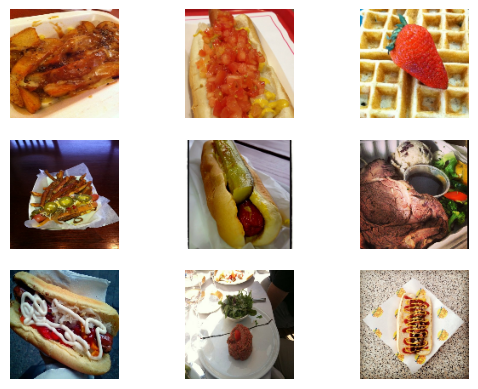

In [32]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [33]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 0, 1, 1, 0, 1, 0, 1], dtype=int32)>

In [34]:
model.save('model_name.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
